In [1]:
import pandas as pd
from editdistance import distance
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from io import StringIO
from html.parser import HTMLParser

In [2]:
df_original = pd.read_csv("data/raw/context_100/ocr_corrections.tsv", sep="\t", encoding="utf8")

In [3]:
df = df_original.rename(columns={"OldTextValue": "oldtext", "NewTextValue": "newtext"})

### Preprocessing

In [4]:
document_id_pattern = r"(?P<title>[A-Za-z]+)(?P<year>[12]\d{3})(?P<month>[01]\d)(?P<day>[0123]\d)?(-(?P<issue>\d{1,2}))?"

In [5]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


def strip_nlib_watermark(s):
    watermark = "@@@@@_NationalLibraryofEstonia_DigitalCollectionsData_SeeUsageRights_in_data.digar.ee_@@@@@"
    if watermark in s:
        return s.replace(watermark, "")
    elif "@@" in s:
        if len(s) - s.index("@@") < 90:
            return s[:s.index("@@")]
    else:
        return s


def clean_text(s):
    return strip_nlib_watermark(strip_tags(s))

In [6]:
def extract_name_and_year(documentID: str, pattern=document_id_pattern):
    if type(documentID) == str:
        match = re.match(pattern, documentID)
        if match:
            title, year = match.groups()[:2]
            return title, int(year)

In [7]:
def count_symbol_types(s: str):
    l = len(s)
    numbers = sum(c.isdigit() for c in s)
    letters = sum(c.isalpha() for c in s)
    spaces  = sum(c.isspace() for c in s)
    others  = len(s) - numbers - letters - spaces

    return (letters/l, numbers/l, spaces/l, others/l)

In [8]:
# create unique IDs across blocks
df["blockIDunique"] = df["pageOID"] + df["blockID"]

In [9]:
# extract dates and titles
df[["title", "year"]] = df.DocumentID.apply(extract_name_and_year).to_list()

In [10]:
# clean HTML tags and @@@@ watermarks from text
df["oldtext"] = df["oldtext"].apply(clean_text)
df["newtext"] = df["newtext"].apply(clean_text)
df["context_old"] = df["context_old"].apply(clean_text)
df["context_new"] = df["context_new"].apply(clean_text)

In [11]:
# calculate text lengths and increase in length, absolute + relative
df["len_old"] = df["oldtext"].str.len()
df["len_new"] = df["newtext"].str.len()
df["len_increase"] = df["len_new"] - df["len_old"]
df["len_increase_relative"] = df["len_increase"] / df["len_old"]

In [12]:
# remove all rows where the old or new text turned out to bo 0 after cleaning
df = df.loc[(df["context_old"].str.len() > 0) & (df["context_new"].str.len() > 0) & (df["oldtext"].str.len() > 0) & (df["newtext"].str.len() > 0)].copy()

In [13]:
# count share of letter, number, special characters and whitespaces
df[["old_string", "old_number", "old_space", "old_other"]] = df["context_old"].apply(count_symbol_types).to_list()
df[["new_string", "new_number", "new_space", "new_other"]] = df["context_new"].apply(count_symbol_types).to_list()

In [14]:
# calculate edit distance, absolute + relative
df["edit_distance"] = df.apply(lambda row: distance(row.oldtext, row.newtext), axis=1)
df["edit_distance_relative"] = df["edit_distance"] / df["len_old"]

In [15]:
# add OCR accuracy on page-level
meta = pd.read_csv("data/raw/context_100/corrected_pages_meta.tsv", sep="\t", encoding="utf8")
meta.replace({"PageOCRAccuracy": "%"}, None, inplace=True)
meta["page_ocr_acc"] = meta["PageOCRAccuracy"].apply(lambda x: float(x.strip("%"))/100 if type(x) == str else None)
df["ocr_acc"] = df["pageOID"].map(meta.set_index("PageID")["page_ocr_acc"])

### Filtering

In [16]:
# group by blocks and add the number of edits on each block
blocks = df.groupby("blockIDunique")[["len_increase_relative", "edit_distance_relative", "new_string", "ocr_acc"]].mean()
blocks["blocksize"] = blocks.index.map(df["blockIDunique"].value_counts())

In [17]:
# filter out desired blocks
blocks = blocks.loc[(blocks["new_string"] > 0.8) & (blocks["edit_distance_relative"] > 0.1)]

In [18]:
def block_samples(blockIDunique, n=10, samples_from="text"):
    block = df.loc[df["blockIDunique"] == blockIDunique]
    if samples_from == "text":
        columns = ["oldtext", "newtext"]
    elif samples_from == "context":
        columns = ["context_old", "context_new"]
    return block.sample(min(n, len(block)))[columns].values

In [22]:
# for ID in blocks.sort_values(by="blocksize", ascending=False).index[:10]:
#     print("\n", ID, "\t\t\t", blocks.loc[ID, "blocksize"])
#     print(block_samples(ID, 1, "text"))
#     print(df.loc[df["blockIDunique"] == ID, "context_from"].unique())

In [20]:
print(len(blocks))

17423


In [25]:
TOP_N_SAMPLES = 10000
selection = df.loc[df["blockIDunique"].isin(blocks.sort_values(by="blocksize", ascending=False).index[:TOP_N_SAMPLES])].convert_dtypes()
selected_blockIDs = selection["blockIDunique"].unique()

In [26]:
with open("data/raw/extracted_ocr_pages2.txt", "r", encoding="utf8") as f:
    pages = f.readlines()
    pages = [line.split("\t") for line in pages]

pages = pd.DataFrame(pages, columns=["pageOID", "fulltext"])

### Reconstruction

In [124]:
def get_article_span(ID):

    ### only edits from this block
    block_df = df.loc[df["blockIDunique"] == ID].sort_values(by="lineID")
    pageOID = block_df["pageOID"].unique()[0]
    context_from = block_df["context_from"].mode()
    if context_from.empty:
        context_from = "new" # if context_from is missing, assume that is new
        block_df["context_from"] = block_df["context_from"].fillna("new")
    else:
        context_from = context_from.values[0] # edit direction
    block_df = block_df.loc[block_df["context_from"] == context_from] # exclude other direction and nan

    # get the full text of the page and clean it
    fulltext = pages.loc[pages["pageOID"] == pageOID, "fulltext"].values[0]
    fulltext = clean_text(fulltext)

    # define source and target columns for replacement
    if context_from == "new":
        source_col = "newtext"
        target_col = "oldtext"
    elif context_from == "old":
        source_col = "oldtext"
        target_col = "newtext"

    # get the edits and their indices
    edits = block_df[source_col]
    edits_in_fulltext = edits[edits.apply(lambda s: s in fulltext)]
    index_is_increasing = (edits_in_fulltext.apply(lambda s: fulltext.index(s)).diff() > 0)
    try:
        first_edit = edits_in_fulltext.iloc[0]
        last_edit = edits_in_fulltext[index_is_increasing].iloc[-1]
    except:
        print(len(edits_in_fulltext), ID)
        return None, None
    
    # replace substrings
    span_existing = fulltext[fulltext.index(first_edit):fulltext.index(last_edit)+len(last_edit)]
    span_reconstructed = span_existing
    for src, tgt in block_df[[source_col, target_col]].values:
        span_reconstructed = span_reconstructed.replace(src, tgt)

    if context_from == "new":
        return (span_reconstructed, span_existing)
    elif context_from == "old":
        return (span_existing, span_reconstructed)

In [125]:
get_article_span(ID)

('pikamõõöuNSte asjade', 'Pikamõõduliste asjade')

In [126]:
df.loc[df.blockIDunique == ID]

,pageOID,blockID,lineID,DocumentID,oldtext,newtext,context_old,context_new,context_from,blockIDunique,...,old_number,old_space,old_other,new_string,new_number,new_space,new_other,edit_distance,edit_distance_relative,ocr_acc
177702,AKriigiteataja19250618.1.20,P20_TB00004,P20_TL00058,AKriigiteataja19250618,pikamõõöu,Pikamõõdu,i kohta ja magun saade tuste tariifi käsitamis...,e pikkus ulatab laiaroopalisel raudteel üle 9 ...,NaN,AKriigiteataja19250618.1.20P20_TB00004,...,0.059603,0.112583,0.052980,0.822967,0.019139,0.133971,0.023923,2,0.222222,0.829
177703,AKriigiteataja19250618.1.20,P20_TB00004,P20_TL00059,AKriigiteataja19250618,NSte asjade,liste asjade,a magun saade tuste tariifi käsitamisel mitte ...,ulatab laiaroopalisel raudteel üle 9 meetri ja...,NaN,AKriigiteataja19250618.1.20P20_TB00004,...,0.063380,0.105634,0.056338,0.825472,0.018868,0.132075,0.023585,3,0.272727,0.829


In [123]:
ID = "AKriigiteataja19250618.1.20P20_TB00004"

block_df = df.loc[df["blockIDunique"] == ID].sort_values(by="lineID")
pageOID = block_df["pageOID"].unique()[0]
context_from = block_df["context_from"].mode()
if context_from.empty:
    context_from = "new" # if context_from is missing, assume that is new
    block_df["context_from"] = block_df["context_from"].fillna("new")
else:
    context_from = context_from.values[0] # edit direction
block_df = block_df.loc[block_df["context_from"] == context_from] # exclude other direction and nan

# get the full text of the page and clean it
fulltext = pages.loc[pages["pageOID"] == pageOID, "fulltext"].values[0]
fulltext = clean_text(fulltext)

# define source and target columns for replacement
if context_from == "new":
    source_col = "newtext"
    target_col = "oldtext"
elif context_from == "old":
    source_col = "oldtext"
    target_col = "newtext"

# get the edits and their indices
edits = block_df[source_col]
edits_in_fulltext = edits[edits.apply(lambda s: s in fulltext)]
index_is_increasing = (edits_in_fulltext.apply(lambda s: fulltext.index(s)).diff() > 0)

first_edit = edits_in_fulltext.iloc[0]
last_edit = edits_in_fulltext[index_is_increasing].iloc[-1]

In [67]:
data  = []

for ID in selected_blockIDs[:1000]:
    pageOID = selection.loc[selection["blockIDunique"] == ID]["pageOID"].unique()[0]
    try:
        old, new = get_article_span(ID)
    except:
        print("error:", ID)
    data.append((ID, pageOID, old, new))


1 AKriigiteataja19181127.1.1P1_TB00008
2 AKriigiteataja19190219.1.2P2_TB00003
1 AKriigiteataja19190307.1.5P5_TB00005
2 AKriigiteataja19190423.1.3P3_TB00004
2 AKriigiteataja19190613.1.8P8_CB00013
1 AKriigiteataja19190823.1.1P1_TB00007
1 AKriigiteataja19200128.1.5P5_TB00004
1 AKriigiteataja19200218.1.11P11_TB00002
1 AKriigiteataja19200218.1.9P9_TB00001
2 AKriigiteataja19210118.1.3P3_TB00002
1 AKriigiteataja19210708.1.3P3_TB00001
1 AKriigiteataja19220502.1.3P3_TB00006
2 AKriigiteataja19220512.1.1P1_TB00013
1 AKriigiteataja19220825.1.1P1_TB00010
1 AKriigiteataja19220901.1.13P13_TB00001
1 AKriigiteataja19221023.1.1P1_TB00008
1 AKriigiteataja19221025.1.1P1_TB00008
1 AKriigiteataja19221121.1.14P14_TB00002
1 AKriigiteataja19221121.1.6P6_TB00001
1 AKriigiteataja19221222.1.2P2_TB00006
0 AKriigiteataja19230108.1.2P2_TB00005
1 AKriigiteataja19230301.1.6P6_TB00006
1 AKriigiteataja19230301.1.8P8_TB00006
1 AKriigiteataja19230322.1.6P6_TB00003
2 AKriigiteataja19230720.1.12P12_TB00004
1 AKriigiteataja1

In [40]:
spans = pd.DataFrame(data, columns=["blockIDunique", "pageOID", "oldtext", "newtext"])
spans["distance"] = spans.apply(lambda row: distance(row.oldtext, row.newtext), axis=1)
spans["distance_relative"] = spans.distance / spans.oldtext.str.len()
spans[["title", "year"]] = spans["pageOID"].apply(lambda x: extract_name_and_year(x.split(".")[0])).to_list()
spans["len_increase"] = spans.apply(lambda row: (len(row.newtext) - len(row.oldtext)) / len(row.newtext), axis=1)

In [41]:
MAX_LEN_CHANGE = 0.05
spans = spans.loc[spans["len_increase"].abs() <= MAX_LEN_CHANGE]

In [45]:
spans.to_csv("data/raw/reconstructed_spans_2000.tsv", sep="\t", encoding="utf8", index=False)

In [43]:
first_100 = blocks.sort_values(by="blocksize", ascending=False).index[:TOP_N_SAMPLES][:100]
last_100 = blocks.sort_values(by="blocksize", ascending=False).index[:TOP_N_SAMPLES][-100:]

In [44]:
spans.loc[spans.blockIDunique.isin(last_100)].sample()[["oldtext", "newtext"]].values

array([['VM pölewttwi Sohtla kaevanduses uurimas, seletaS meie kaastöölisele: „Põlewkiwi lademeid leidub ka mujal maades, nagu ColoradoS, Rew-BrunSvickis, Bulgaarias ja Ehottmaal. Ameerika ja Bulgaaria põlewNwi olevat võrdlemisi hea, Ehott oma alaväärtusline. Seni olnud põlevkivi tööstus igal pool algastmel ja üksikud katsed äpardanud. Lähemas tulevikus aga tahtwat Ameerika hakata oma pölewkiwi lademeid suuremal määral kasutama. Eesti põlewttwi olewat oma omaduLte poolest kõige »arem maailmas. Ümbertöötamisel peaks temast hinnalisi õlisid saama, nagu petrooleumi, bensiini jne., mida võiks wälja wedada ja selle vastu sisse tuua kivisütt, mille küte tuleks märksa odawam, kui ttwi tooresainena kasutamine. Ajajooksul võidakse ka EeSLiS üle minna õlitüttele, nagu Inglismaal ja Ameerikas. Aga selleks, et põlewttwi tööstust nõuetavale järjele seada, olewat tarwiS määratu',
        'käis põlewlkiwi Kohtla kaevanduses uurimas, seletas meie kaastöölisele: „Põlewkiwi lademeid leidub ka mujal maad

In [224]:
#spans.to_csv("data/fine-tuning/training_data_w_meta_2000_raw.tsv", sep="\t", encoding="utf8", index=False)

### Exploration

<Axes: >

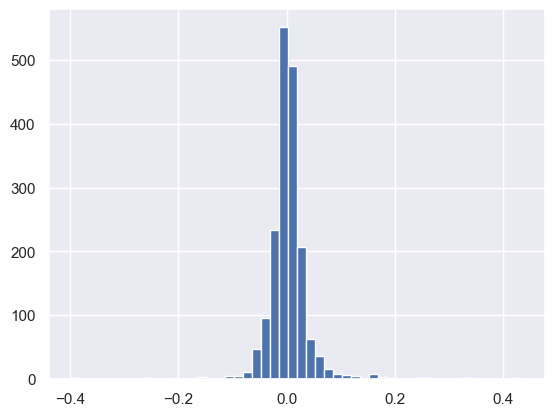

In [174]:
spans.len_increase.hist(bins=50)

In [99]:
year_counts = spans["year"].value_counts().sort_index()
year_range = range(year_counts.index.min(), year_counts.index.max() + 1)
reindexed_counts = year_counts.reindex(year_range, fill_value=0)

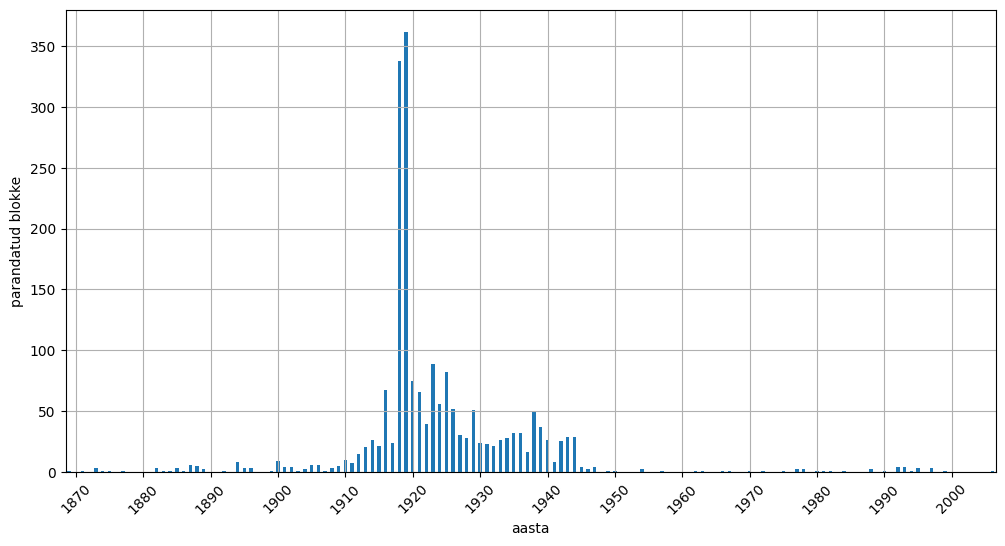

In [100]:
plt.figure(figsize=(12,6))
reindexed_counts.plot(kind="bar")
ticks_to_show = [year for year in reindexed_counts.index if year % 10 == 0]
plt.xticks(ticks=[reindexed_counts.index.get_loc(year) for year in ticks_to_show], labels=ticks_to_show, rotation=45, ha="center")
plt.grid()
plt.xlabel("aasta")
plt.ylabel("parandatud blokke")
plt.show()

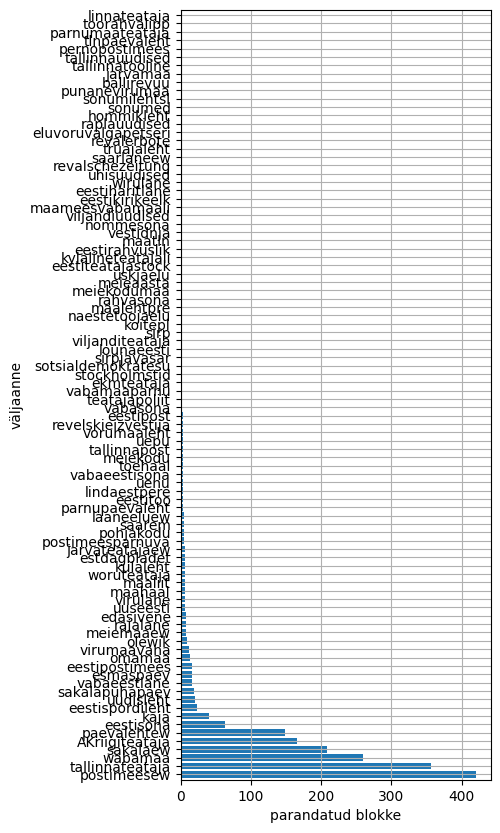

In [101]:
plt.figure(figsize=(4,10))
title_counts = spans["title"].value_counts()
title_counts.plot(kind="barh", width=0.8)
plt.xlabel("parandatud blokke")
plt.ylabel("väljaanne")
plt.grid()
plt.show()

In [102]:
titles_over_n1 = title_counts.loc[lambda x: x > 1].index
top_titles = spans.loc[spans["title"].isin(titles_over_n1)].copy()
top_titles["title"] = pd.Categorical(top_titles["title"], categories=titles_over_n1)

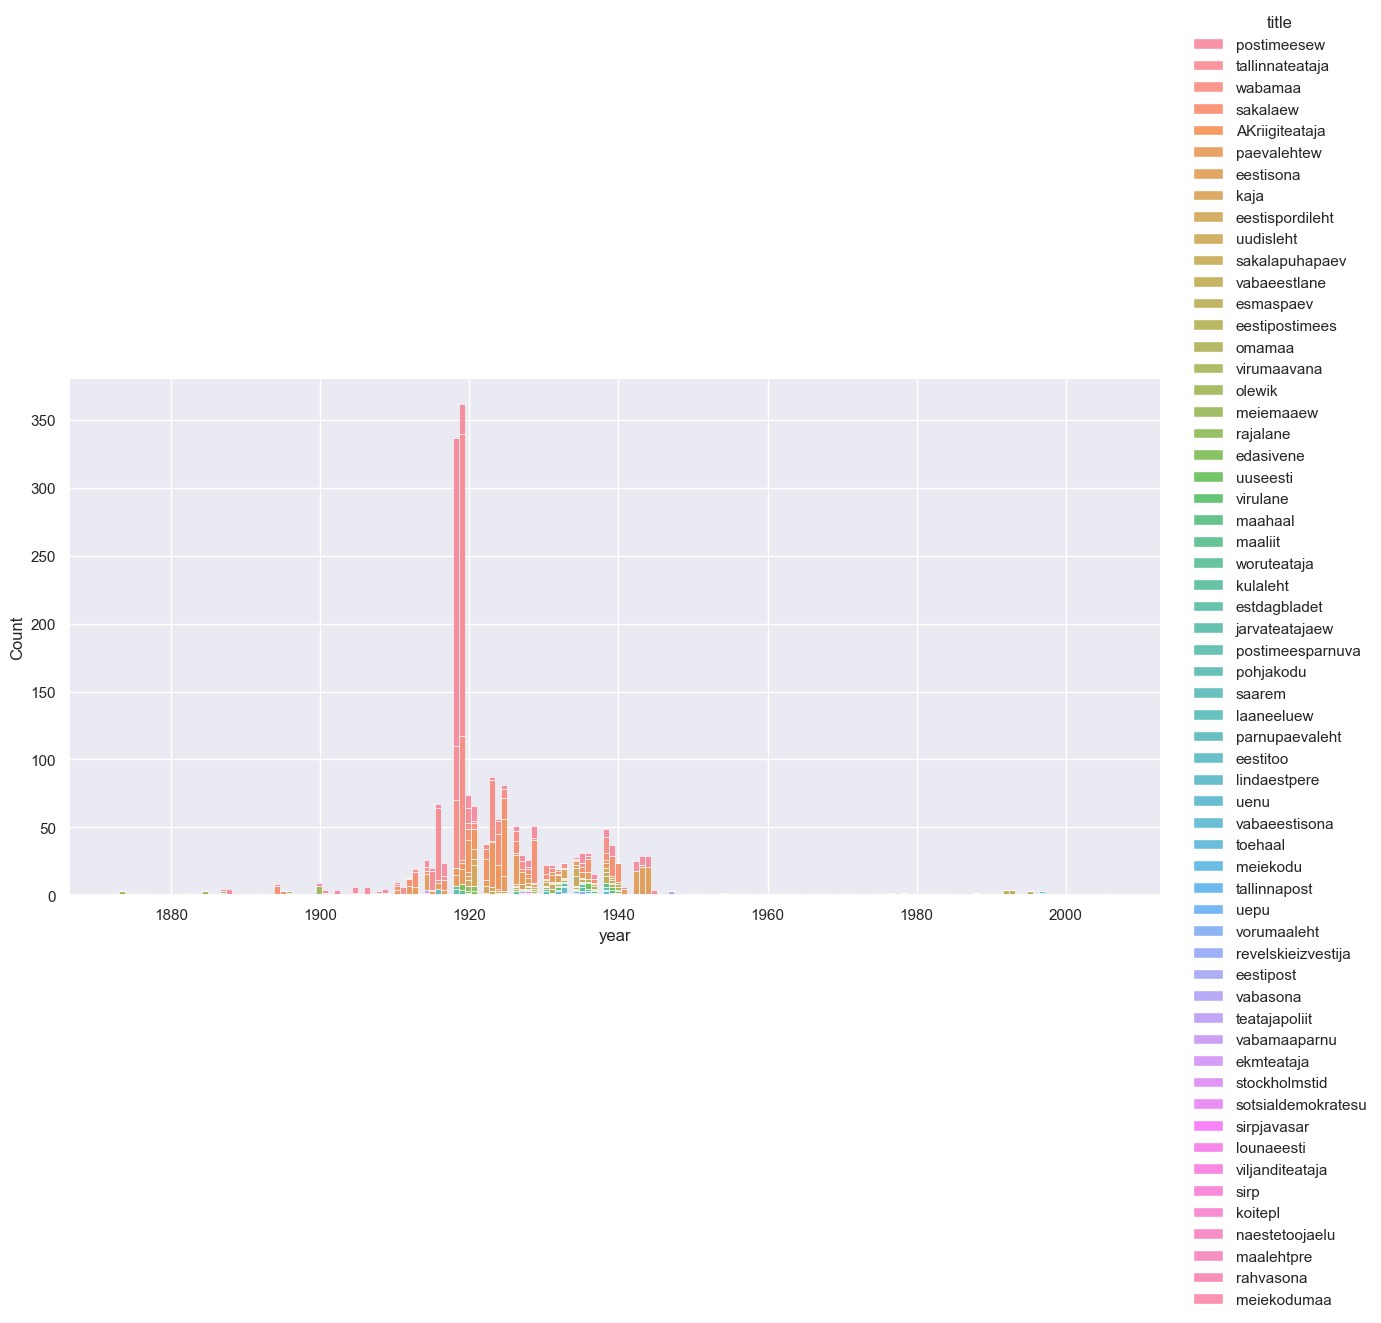

In [103]:
sns.set_theme()
sns.displot(top_titles, x="year", hue="title", height=6, aspect=2, binwidth=0.8, kind="hist", multiple="stack")
plt.show()

### Content moderation

In [104]:
import os
from openai import OpenAI
from dotenv import load_dotenv
import time

In [105]:
load_dotenv()
API_KEY = os.getenv("MY_API_KEY")
client = OpenAI(api_key=API_KEY)

In [106]:
moderation_categories = ['harassment',
 'harassment_threatening',
 'hate',
 'hate_threatening',
 'self_harm',
 'self_harm_instructions',
 'self_harm_intent',
 'sexual',
 'sexual_minors',
 'violence',
 'violence_graphic',
 'self-harm',
 'sexual/minors',
 'hate/threatening',
 'violence/graphic',
 'self-harm/intent',
 'self-harm/instructions',
 'harassment/threatening']

In [107]:
def insert_ocr_to_prompt(OCR, prompt_template):
    return prompt_template.format(ocr_transcription=OCR)

In [108]:
def get_moderation_categories(text):
    mod = client.moderations.create(input=text)
    return mod.results[0].flagged, dict(mod.results[0].categories)

In [109]:
def check_training_data_moderation(spans, delay=None):

    flagged_old = []
    flagged_new = []
    
    for _, row in spans.iterrows():
        oldtext_flag, oldtext_categories = get_moderation_categories(insert_ocr_to_prompt(row.oldtext, PROMPT_TEMPLATES["template-001"]))
        if oldtext_flag == True:
            flagged_old.append({row.blockIDunique: oldtext_categories})
        
        newtext_flag, newtext_categories = get_moderation_categories(row.newtext)
        if newtext_flag == True:
            flagged_new.append({row.blockIDunique: newtext_categories})

        if delay:
            time.sleep(delay)

    return flagged_old, flagged_new

In [113]:
### 300 spans
spans_2000 = pd.read_csv("data/fine-tuning/training_data_w_meta_2000_raw.tsv", sep="\t", encoding="utf8")
flagged_old, flagged_new = check_training_data_moderation(spans_2000, delay=0.3)

In [138]:
print(len(flagged_old))
print(len(flagged_new))
print((len(flagged_old) + len(flagged_new)))# / len(spans_300)*2

24
229
253


In [139]:
flagged_old_list = [list(entry.keys())[0] for entry in flagged_old]
flagged_new_list = [list(entry.keys())[0] for entry in flagged_new]

In [191]:
with open("data/fine-tuning/flagged_blocks.json", "w", encoding="utf8") as f:
    json.dump(
        {"flagged_old": flagged_old_list,
         "flagged_new": flagged_new_list},
         f)

In [143]:
with open("data/fine-tuning/flagged_blocks.json", "r", encoding="utf8") as f:
    flagged = json.load(f)["flagged_new"]

In [154]:
to_remove = []
for span in spans.blockIDunique[::-1].values:
    if span in flagged:
        if len(to_remove) <= 41:
            to_remove.append(span)

In [146]:
spans_2000_moderated = spans.loc[~spans.blockIDunique.isin(to_remove)]
print(len(spans_2000_moderated))

1311


In [233]:
spans_2000_moderated.to_csv("data/fine-tuning/training_data_w_meta_2000_moderated.tsv", sep="\t", encoding="utf8", index=False)

### Fine-tuning preparation

In [157]:
spans = pd.read_csv("data/raw/reconstructed_spans_2000.tsv", sep="\t", encoding="utf8")

In [158]:
ratings_df = pd.read_json("data/fine-tuning/ocr_ratings.jsonl", lines=True)
spans = pd.merge(spans, ratings_df)

In [159]:
spans = spans.loc[spans.newtext_rating == 5]

In [160]:
spans = spans.loc[~spans.blockIDunique.isin(to_remove)]
print(len(spans))

1300


In [132]:
PROMPT_TEMPLATES = {
    "template-001": "Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents in Estonian. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. The text to correct appears after the segment 'TEXT TO CORRECT:'. Please place the corrected version of the text after the 'CORRECTED TEXT:' segment. Do not write anything else than the corrected text.\n\n TEXT TO CORRECT:\n {ocr_transcription} \n CORRECTED TEXT:",
    "template-002": "Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical Estonian newspapers. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. The text to correct appears after the segment 'TEXT TO CORRECT:'. Please place the corrected version of the text after the 'CORRECTED TEXT:' segment. Do not write anything else than the corrected text.\n\n TEXT TO CORRECT:\n {ocr_transcription} \n CORRECTED TEXT:"
}

In [161]:
def format_training_data(df, prompt_template):
    formatted_data = []
    for (OCR, GT) in list(zip(spans["oldtext"], spans["newtext"])):
        prompt = prompt_template.format(ocr_transcription=OCR)
        formatted_data.append(
            {"messages": [{"role": "user", "content": prompt}, {"role": "assistant", "content": GT}]}
        )

    return formatted_data

In [162]:
data = format_training_data(spans, PROMPT_TEMPLATES["template-002"])

In [163]:
with open("data/fine-tuning/training_data_1300.jsonl", "w", encoding="utf8") as f:
    for entry in data:
        f.write(json.dumps(entry))
        f.write("\n")

: 

### Pricing

In [137]:
import tiktoken

In [138]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [139]:
total_text = ""
for entry in data:
    for message in entry["messages"]:
        for key, val in message.items():
            if key == "content":
                total_text += val

In [140]:
n_tokens = len(encoding.encode(total_text))
print(n_tokens)

1868241


In [141]:
price_per_1m = 8
tokens_m = n_tokens / 1000000
price_per_epoch = tokens_m * price_per_1m
print(price_per_epoch)

14.945928


In [142]:
del(total_text)